In [1]:
# Import Data from Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import Libraries
import pandas as pd # Data analysis and manipulation tool
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score, recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay # Import essential metrics to evaluate
import xgboost #Using XGBClassifier to do classify task, there also XGBRegression to do predict task
import matplotlib.pyplot as plt # Use for creating chart
import seaborn as sns # Use with matplotlib to visualize
import warnings # Suppress Warning

In [3]:
# Suppress Future Warning
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
'''
Read dataset from Drive
Using pandas to read parquet files because the dataset are using .parquet extension
There are 2 dataset, one for test and another for train.
'''
df_test = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/NSL-KDD/KDDTest.parquet')
df_train = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/NSL-KDD/KDDTrain.parquet')

# Show statistics of dataset. Using .shape property, it shows (total of records (Row), total of Columns)
df_test.shape, df_train.shape

((22544, 43), (125973, 43))

In [5]:
# Show what columns is in the dataset
df_train.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class', 'classnum'],
      dtype='object')

In [6]:
df_train[['duration',	'protocol_type',	'service',	'flag','class']]

,duration,protocol_type,service,flag,class
0,0,tcp,ftp_data,SF,normal
1,0,udp,other,SF,normal
2,0,tcp,private,S0,neptune
3,0,tcp,http,SF,normal
4,0,tcp,http,SF,normal
...,...,...,...,...,...
125968,0,tcp,private,S0,neptune
125969,8,udp,private,SF,normal
125970,0,tcp,smtp,SF,normal
125971,0,tcp,klogin,S0,neptune


In [7]:
# Remove unnessary columns, classnum = Difficulty Number, not nessary in this task
df_train.drop(columns=['classnum'], inplace=True)
df_test.drop(columns=['classnum'], inplace=True)

# Declear a variable to not conflict with function parameter
dep = 'class'

# Show all columns are using the Category datatype - Category in other word is Text
cats = list(df_train.select_dtypes(include='category').columns.values)
cats

['protocol_type', 'service', 'flag', 'class']

In [8]:
# Show numbers of records in each type of class, in train and test
df_train['class'].value_counts(), df_test['class'].value_counts()

(class
 normal             67343
 neptune            41214
 satan               3633
 ipsweep             3599
 portsweep           2931
 smurf               2646
 nmap                1493
 back                 956
 teardrop             892
 warezclient          890
 pod                  201
 guess_passwd          53
 buffer_overflow       30
 warezmaster           20
 land                  18
 imap                  11
 rootkit               10
 loadmodule             9
 ftp_write              8
 multihop               7
 phf                    4
 perl                   3
 spy                    2
 udpstorm               0
 snmpguess              0
 worm                   0
 sqlattack              0
 xlock                  0
 xsnoop                 0
 apache2                0
 snmpgetattack          0
 sendmail               0
 saint                  0
 ps                     0
 processtable           0
 named                  0
 mscan                  0
 mailbomb               0
 http

In [9]:
'''
To classify abnormal behavior, add a new class 'malicious'
Convert all not 'normal' to 'malicious'
'''

# Add a new class 'malicious'
df_train['class'] = df_train['class'].cat.add_categories(['malicious'])
df_test['class'] = df_test['class'].cat.add_categories(['malicious'])

# Convert all NOT 'normal' to 'malicious'
df_train.loc[df_train['class'] != 'normal', 'class'] = 'malicious'
df_test.loc[df_test['class'] != 'normal', 'class'] = 'malicious'

# Set 'class' to Category datatype and order it: 2 types ['normal' < 'malicious']
df_train['class'] = df_train['class'].cat.set_categories(['normal', 'malicious'], ordered=True)
df_test['class'] = df_test['class'].cat.set_categories(['normal', 'malicious'], ordered=True)

# Make sure there are only 'normal' and 'malicious' classes
df_train['class'] = df_train['class'].cat.remove_unused_categories()
df_test['class'] = df_test['class'].cat.remove_unused_categories()

# Show records of dataset
print(df_train.shape, df_test.shape)

(125973, 42) (22544, 42)


In [10]:
# Show total of Normal and Malicious in Train and Test
df_train['class'].value_counts(), df_test['class'].value_counts()

(class
 normal       67343
 malicious    58630
 Name: count, dtype: int64,
 class
 malicious    12833
 normal        9711
 Name: count, dtype: int64)

In [11]:
# Check datatype and category of train set
df_train['class'].dtype

CategoricalDtype(categories=['normal', 'malicious'], ordered=True, categories_dtype=object)

In [12]:
# Encode all Categories columns to Numerical Variable to feed XGBoost
df_train[cats] = df_train[cats].apply(lambda x: x.cat.codes)
df_test[cats] = df_test[cats].apply(lambda x: x.cat.codes)

In [13]:
'''
Utility Function to Extract Feature(X) and Label(Y) from Dataset
Feature: all columns except class
Label: Class columns, used as a target to classify
'''
def xs_y(df_, targ):
    '''
    Allow Targ (Label) to be List or Single value
    xs: Copy all columns that not targ
    '''
    if not isinstance(targ, list):
        xs = df_[df_.columns.difference([targ])].copy()
    else:
        xs = df_[df_.columns.difference(targ)].copy()
    # Copy targ to y
    y = df_[targ].copy()
    # Return Features and Label
    return xs, y

In [14]:
# Split train and test to Xs and Y
X_train, y_train = xs_y(df_train, dep)
X_test, y_test = xs_y(df_test, dep)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((125973, 41), (125973,), (22544, 41), (22544,))

In [15]:
# Define XGBoost Classifier Hyperparameter: Not Optimized
xgb = xgboost.XGBClassifier(
        n_estimators= 100, # 100 boosting rounds, in this case it is 100 Decision Trees
        max_depth= 8, # When Decision Tree reach 8 depths, It will begin Prune process
        booster= 'gbtree', # Use Decision tree as Weak Learner
        subsample= 0.5, # Take a part (50%) of Training for each Tree
        colsample_bytree= 0.5, # Take a part (50%) of Feature for each Tree
        importance_type= 'gain', # Choose Gain metric to evaluate Feature Importance
        objective='binary:logistic', # Objective of the task is Classification, so Binary Classification with Logistic Regression
        eval_metric='logloss', # Use 'logloss' as a metric to evaluate model in Training
    )

Iteration 0: Train Logloss: 0.44553, Test Logloss: 0.58154
Iteration 10: Train Logloss: 0.02396, Test Logloss: 0.55933
Iteration 20: Train Logloss: 0.00511, Test Logloss: 0.781
Iteration 30: Train Logloss: 0.0027, Test Logloss: 0.84071
Iteration 40: Train Logloss: 0.00171, Test Logloss: 0.87189
Iteration 50: Train Logloss: 0.00134, Test Logloss: 0.89558
Iteration 60: Train Logloss: 0.00111, Test Logloss: 0.92633
Iteration 70: Train Logloss: 0.00094, Test Logloss: 0.93647
Iteration 80: Train Logloss: 0.00083, Test Logloss: 0.99037
Iteration 90: Train Logloss: 0.00073, Test Logloss: 0.98633


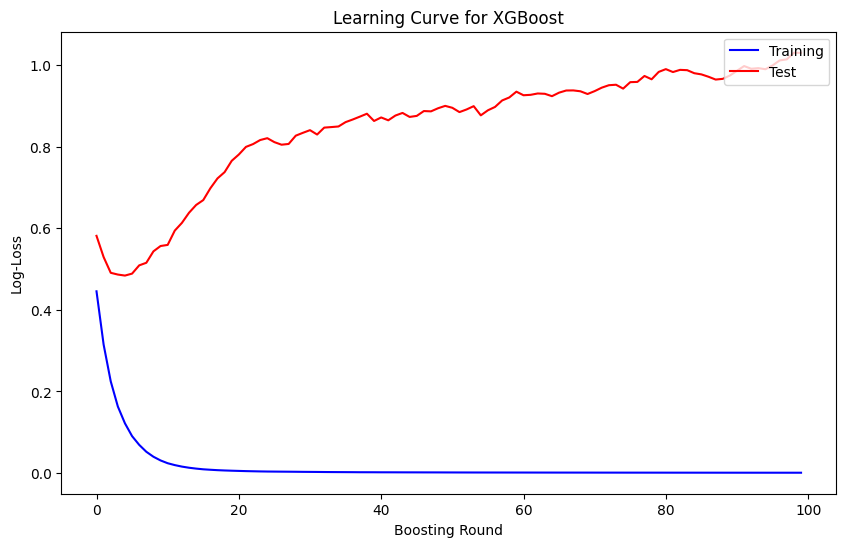

In [16]:
xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test,y_test)],  # Monitor training and test sets
    verbose = False, # Prevent it make output
)

result = xgb.evals_result() # Get the Evalution Result

# Extract log-loss values
train_logloss = result['validation_0']['logloss']
test_logloss = result['validation_1']['logloss']

# Print log-loss for every 10th iteration
for i in range(0, len(train_logloss), 10):
    print(f"Iteration {i}: Train Logloss: {round(train_logloss[i],5)}, Test Logloss: {round(test_logloss[i],5)}")

# Plot the Learning Curve based on Logarith Loss metric
plt.figure(figsize=(10, 6))
plt.plot(result['validation_0']['logloss'], label='Training', color='blue')
plt.plot(result['validation_1']['logloss'], label='Test', color='red')
plt.xlabel('Boosting Round')
plt.ylabel('Log-Loss')
plt.title('Learning Curve for XGBoost')
plt.legend(loc='upper right')
plt.show()

In [17]:
# Classify the test set
xgb_preds = xgb.predict(X_test)

In [18]:
'''
Define DataFrame for the Test classification
Auroc: Area Under the Curve of Receiver Operating Characteristic (ROC)
Accuracy: Accuracy of the classification
Precision: Precision of the classification
Recall: Recall of the classification
F1: F1 Score of the classification
'''
noopt_df = pd.DataFrame(data=[[
        'nslkdd-binary',
        'xgb-no-opt',
        X_train.shape,
        X_test.shape,
        round(roc_auc_score(y_true=y_test, y_score=xgb_preds),4),
        round(accuracy_score(y_true=y_test, y_pred=xgb_preds), 4),
        round(precision_score(y_true=y_test, y_pred=xgb_preds), 4),
        round(recall_score(y_true=y_test, y_pred=xgb_preds), 4),
        round(f1_score(y_true=y_test, y_pred=xgb_preds), 4)
    ]], columns=['AtkCls', 'model', 'TrainShape', 'TestShape', 'Auroc', 'Accuracy', 'Precision', 'Recall', 'F1'])
# Show the DataFrame
noopt_df

,AtkCls,model,TrainShape,TestShape,Auroc,Accuracy,Precision,Recall,F1
0,nslkdd-binary,xgb-no-opt,"(125973, 41)","(22544, 41)",0.8255,0.8052,0.9693,0.6793,0.7988


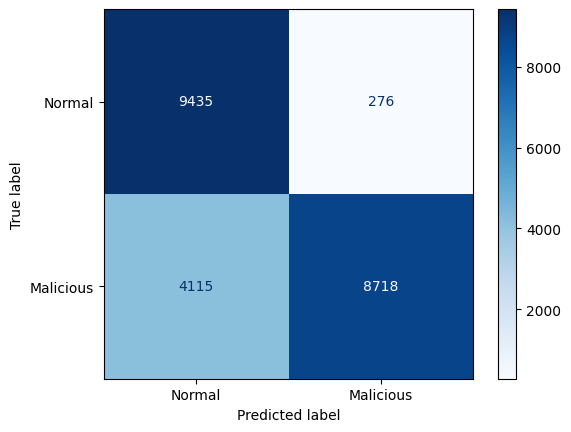

In [19]:
# Define the Confusion Matrix
cm = confusion_matrix(y_test, xgb_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Malicious'])
disp.plot(cmap='Blues')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


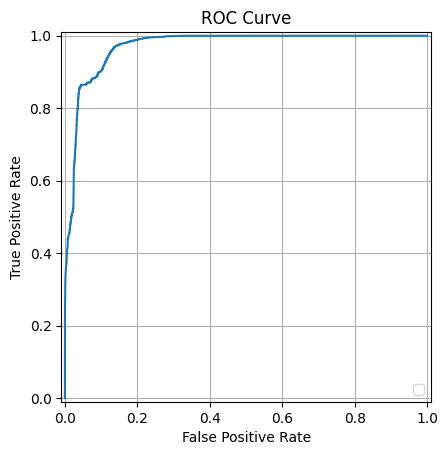

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:, 1])

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

roc_display.plot()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.show()

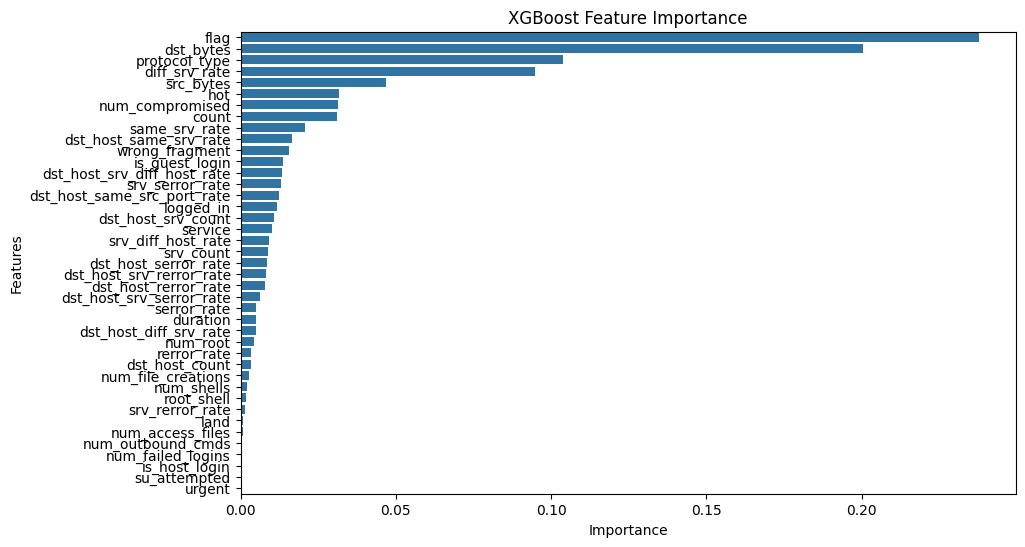

In [21]:
feature_importances = pd.DataFrame(xgb.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances['importance'], y=feature_importances.index)
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [22]:
xgb.save_model("model.bin")  # Save the model

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:57:47] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
